# Hydrometeor Viewer

In [1]:
import numpy as np
import scipy.misc as smp
import matplotlib as mpl
from matplotlib import colors
from matplotlib.widgets import Button
import matplotlib.pyplot as plt
import xarray as xr
import glob

%matplotlib nbagg

Functions to load the particle and image data, & to convert the decimal data to binary.

In [2]:
def get_colors(imageMode):
    if imageMode==0:
        cmap1 = colors.ListedColormap(['black', 'white', 'cyan'])
        bounds=[0,1,2,3]
        norm = colors.BoundaryNorm(bounds, cmap1.N)
        
        return cmap1, bounds, norm

def probe_defaults(probeName):
    invalidSlice = np.array([-1., -1., -1., -1., -1., -1., -1., -1.])
    if probeName=='2DS' or probeName=='HVPS':
        boundary = np.array([43690, 43690, 43690, 43690, 43690, 43690, 43690, 43690])
        boundaryTime = 0;
    elif probeName=='CIP' or probeName=='PIP':
        boundary = np.array([170, 170, 170, 170, 170, 170, 170, 170])
        boundaryTime = 0;
        
    return boundary, boundaryTime, invalidSlice

def get_imageData(inFile, frameStart):
    ds = xr.open_dataset(inFile)
    yr = ds['year'][frameStart-1:frameStart]
    mon = ds['month'][frameStart-1:frameStart]
    day = ds['day'][frameStart-1:frameStart]
    hr = ds['hour'][frameStart-1:frameStart]
    minute = ds['minute'][frameStart-1:frameStart]
    sec = ds['second'][frameStart-1:frameStart]
    msec = ds['millisec'][frameStart-1:frameStart]
    data = ds['data'][frameStart-1:frameStart]
    data = data[0].values
    
    return yr, mon, day, hr, minute, sec, msec, data

def load_partData(inFile, probeName):
    ds1 = xr.open_dataset(inFile)
    time = ds1['Time'].values
    frame = ds1['parent_rec_num'].values
    partNum = ds1['particle_num'].values
    length = ds1['image_length'].values
    longestY = ds1['image_longest_y'].values
    width = ds1['image_width'].values
    dmax = ds1['image_diam_minR'].values
    drec = ds1['image_RectangleL'].values
    dell = ds1['image_EllipseL'].values
    area = ds1['image_area'].values
    perim = ds1['image_perimeter'].values
    reject = ds1['image_auto_reject']
    habit = ds1['holroyd_habit']
    if probeName=='2DS' or probeName=='HVPS':
        tempTime = ds1['Time_in_seconds'] # time in TAS clock cycles
        intArr = np.zeros(len(tempTime.values))
        intArr[1:len(tempTime)] = np.diff(tempTime.values) # time difference between particles
    else:
        intArr = ds1['inter_arrival'].values
    
    return time, frame, partNum, length, longestY, width, dmax, drec, dell, area, perim, reject, habit, intArr

def get_partInfo(probeName, position, partStart, partEnd, hr, minute, sec, frameStart, time, frame, partNum, length,
                 longestY, width, dmax, drec, dell, area, perim, reject, habit, intArr):
    global sel_partNum, timeIndex, frameIndex, partNumIndex
    sel_partNum = np.where((pos[0]>=partStart) & (pos[0]<partEnd))
    if len(sel_partNum[0])==0:
        print('You selected a particle boundary. Please click on a particle instead.')
    else:
        sel_partNum = sel_partNum[0][0]+1
        sel_frame = frameStart
        sel_Time = hr*10000 + minute*100 + sec
    
        partIndex = np.where((time==sel_Time) & (frame==sel_frame) & (partNum==sel_partNum))
        indexShape = (np.asarray(partIndex)).shape
        numMatches = indexShape[1] # number of particles that meet criteria (should always equal 1)
        
        timeIndex = (time[partIndex]).astype(int)
        frameIndex = (frame[partIndex]).astype(int)
        partNumIndex = (partNum[partIndex]).astype(int)
        lengthIndex = (length[partIndex]).astype(int)
        widthIndex = (width[partIndex]).astype(int)
        longestYIndex = (longestY[partIndex]).astype(int)
        dmaxIndex = dmax[partIndex]
        drecIndex = drec[partIndex]
        dellIndex = dell[partIndex]
        areaIndex = area[partIndex]
        perimIndex = perim[partIndex]
        intArrIndex = intArr[partIndex]
        rejectIndex = reject[partIndex]
        habitIndex = habit[partIndex]

        rejectNumArray = np.array([48, 97, 65, 116, 112, 104, 72, 115, 122, 102, 105, 117, 85])
        rejectStrArray = ['Not rejected - 0', 'High aspect ratio - a', 'High area ratio - A',
                          'High aspect ratio touching edge - t', 'Low % shadowed area - p', 'Hollow image - h',
                          'Hollow image - H', 'Split image - s', 'Zero area image - z', 'Fake zero area image - f',
                          'Hollow image - i', 'Hollow image - u', 'Hollow image - U']
        for x in np.arange(0,len(rejectNumArray)):
            if rejectNumArray[x]==rejectIndex.values:
                rejectVal = rejectStrArray[x]

        habitNumArray = np.array([77, 67, 116, 111, 108, 97, 103, 115, 104, 105, 100])
        habitStrArray = ['Zero image','Center out','Tiny','Oriented','Linear','Aggregate','Graupel','Spherical',
                         'Hexagonal','Irregular','Dendrite']
        for x in np.arange(0,len(habitNumArray)):
            if habitNumArray[x]==habitIndex.values:
                habitVal = habitStrArray[x]
    
        if numMatches != 1:
            print('Either no particle was found for the specific frame and particle number, or too many were found.\nPlease select different values.')
        elif probeName=='2DS' or probeName=='HVPS':
            print('Time: {}  Frame: {}  Particle: {}\nLength:{:3d}  Width:{:3d}  LongestY:{:3d}\nDmax:{:6.3f} mm  Dmax (Rectangle):{:6.3f} mm  Dmax (Ellipse):{:6.3f} mm\nArea:{:6.3f} mm^2  Perimeter:{:6.3f} mm  Inter-arrival:{:.2e} s\nReject status: {}  Habit: {}'
                  .format(timeIndex[0],frameIndex[0],partNumIndex[0],lengthIndex[0],widthIndex[0],longestYIndex[0],
                          dmaxIndex[0],drecIndex[0],dellIndex[0],areaIndex[0],perimIndex[0],intArrIndex[0],
                          rejectVal,habitVal))
        else: # different formatting of intArr since these data are in xArray's DataArray format and must be converted
            print('Time: {}  Frame: {}  Particle: {}\nLength:{:3d}  Width:{:3d}  LongestY:{:3d}\nDmax:{:6.3f} mm  Dmax (Rectangle):{:6.3f} mm  Dmax (Ellipse):{:6.3f} mm\nArea:{:6.3f} mm^2  Perimeter:{:6.3f} mm  Inter-arrival:{:.2e} s\nReject status: {}  Habit: {}'
                  .format(timeIndex[0],frameIndex[0],partNumIndex[0],lengthIndex[0],widthIndex[0],longestYIndex[0],
                          dmaxIndex[0],drecIndex[0],dellIndex[0],areaIndex[0],perimIndex[0],intArrIndex[0],
                          rejectVal,habitVal))
                
def get_slice_endpoints(buf): # get particle slice start/end indices, and the indices for the particle boundary
    numPart = 0 # number of particles in buffer
    startInd = [] # index of the start of a particle
    endInd = [] # index of the end of a particle
    boundaryInd = [] # index of the particle boundary (series of 8 consecutive '43690' values)
    
    j = 0
    while (buf[j,0] != -1) and (j+1 < buf.shape[0]):
        if (np.array_equal(buf[j,:],boundary)) and ((buf[j+1,0]==boundaryTime) or (probeName=='CIP') or
                                                   (probeName=='PIP')): # particle boundary
            boundaryInd.append(j)
            if j>0:
                endInd.append(j-1) # index of particle end before the particle boundary (previous particle)
                numPart = numPart + 1 # for particle preceeding boundary
            startInd.append(j+2) # index of particle start after the particle boundary (next particle)
        j = j + 1
    
    boundaryInd = np.array(boundaryInd, dtype='int')
    if (boundaryInd.size>0) or (boundaryInd[0]>0): # no boundaries or first boundary after first slice in buffer
        startInd = np.insert(startInd, 0, 0)
    startInd = np.array(startInd, dtype='int')
    
    if boundaryInd[-1]+3 < buf.shape[0]: # particle occurs after last boundary if it's 3rd from last slice in record
        endInd.append(buf.shape[0]-1) # last particle ends at end of buffer
        endInd = np.array(endInd, dtype='int') 
    else:
        endInd = np.array(endInd, dtype='int') # boundary found at very end of record -- no more particles in buffer
        
    return numPart, boundaryInd, startInd, endInd
    
def buffer_integrity(partCount, boundaryInd, partStart, partEnd):
    print('There are {} particles and {} boundaries.'.format(partCount, len(boundaryInd)))
    if np.any(partEnd-partStart<0): # particle end indices NOT >= start indices [ERROR]
        print('Error with particle start/end indices!')
    else:
        print('Particle start/end indices look OK.')
        
def image_buffer(buf, probeName, boundaryInd): # generate matrix of 1's and 0's from buffer
    if probeName=='2DS' or probeName=='HVPS':
        boundaryData = np.tile([2,2,1,1], 32) # alternate 1's and 2's for boundary slice (white & cyan pixels)
        buf[buf==-1] = 0 # change invalid values to 0 (unshadowed segment)
        buf = 65535 - buf # 0: shadowed; 1: unshadowed
        
        # convert decimal to binary (8 image words for each slice)
        imageData = np.ones([1700,128]) # set up image buffer (1's mean unshadowed pixels)

        for x in np.arange(buf.shape[0]):
            tempBuf = np.array([np.binary_repr(buf[x,0],16), np.binary_repr(buf[x,1],16), np.binary_repr(buf[x,2],16),
                                np.binary_repr(buf[x,3],16), np.binary_repr(buf[x,4],16), np.binary_repr(buf[x,5],16),
                                np.binary_repr(buf[x,6],16), np.binary_repr(buf[x,7],16)])
            sliceBuf = []
            for y in np.arange((buf.shape[1])*16):
                sliceBuf.append(tempBuf[(np.floor(y/16)).astype(int)][np.mod(y,16)])
            sliceBuf = np.asarray(sliceBuf, dtype='int')
            imageData[x,:] = sliceBuf
    elif probeName=='CIP' or probeName=='PIP':
        boundaryData = np.tile([2,2,1,1], 16) # alternate 1's and 2's for boundary slice (white & cyan pixels)
        buf[buf==-1] = 255 # change invalid values to 0 (unshadowed segment)
        
        # convert decimal to binary (8 image words for each slice)
        imageData = np.ones([1700,64]) # set up image buffer (1's mean unshadowed pixels)

        for x in np.arange(buf.shape[0]):
            tempBuf = np.array([np.binary_repr(buf[x,0],8), np.binary_repr(buf[x,1],8), np.binary_repr(buf[x,2],8),
                                np.binary_repr(buf[x,3],8), np.binary_repr(buf[x,4],8), np.binary_repr(buf[x,5],8),
                                np.binary_repr(buf[x,6],8), np.binary_repr(buf[x,7],8)])
            sliceBuf = []
            for y in np.arange((buf.shape[1])*8):
                sliceBuf.append(tempBuf[(np.floor(y/8)).astype(int)][np.mod(y,8)])
            sliceBuf = np.asarray(sliceBuf, dtype='int')
            imageData[x,:] = sliceBuf

    imageData[boundaryInd,:] = boundaryData # write in boundary slice
    
    if boundaryInd[-1]+1 < buf.shape[0]:
        imageData[boundaryInd+1,:] = 1.
    else:
        imageData[boundaryInd[0:-2]+1,:] = 1.
    
    return(imageData)

def annotate_particle_incriments(boundaryInd): # get indices along buffer for every 5 particles (optional plotting)
    partInds = boundaryInd[np.arange(3,(boundaryInd.size)-1, 5)]+1
    
    return partInds

User inputs go here. A few notes:
- partFile: file path to particle-by-particle file (output data from image_proc_sm.m script)
- probeName: '2DC', '2DP', 'CIP', 'PIP', '2DS', 'HVPS'
- campaign: 'plows', 'mc3e', 'gcpex', 'pecan', 'olympex', etc.
- date: 'yyyymmdd' (for file output path)
- annotate: 1 - a red asterisk is overlaid every 5 particles (useful for matching w/ PBP data); 0 - no annotations
- imageMode: 0 - all particles shaded black; 1 - rejected particles shaded blue; 2 - particles shaded by reject code; 3 - particles shaded by habit
- inFile: file path to decompressed image file (ouput data from read_binary_*.m script)
- frameStart: initial frame number to initiate plotting code

In [3]:
partFile = '/data/gpm/a/shared/finlon2/gcpex/processed/20120218a/procCIP.20120218a.cdf'#'/data/gpm/a/shared/finlon2/olympex/processed/20151203/proc2DS.20151203.V.cdf'
probeName = 'CIP'#'2DS'
[time, frame, partNum, length, longestY, width, dmax, drec, dell, area, perim, reject, habit, intArr] = load_partData(
    partFile, probeName)

In [4]:
campaign = 'gcpex'; date = '20120218a'#'20151203'
annotate = 1.; imageMode = 0.
imageFile = '/data/gpm/a/shared/finlon2/gcpex/image_data/20120218a/CIP.20120218a.cdf'#'/data/gpm/a/shared/finlon2/olympex/image_data/20151203/2DS.20151203.V.cdf'
frameStart = 200#347995

[cmap1, bounds, norm] = get_colors(imageMode)
[boundary, boundaryTime, invalidSlice] = probe_defaults(probeName)
[yr, mon, day, hr, minute, sec, msec, data] = get_imageData(imageFile, frameStart)
[partCount, boundaryInd, partStart, partEnd] = get_slice_endpoints(data)
img = image_buffer(data, probeName, boundaryInd)

frameNo = frameStart

Plot image record, with abiliy to select a particlular particle or to advance/rewind frame by frame.

<IPython.core.display.Javascript object>


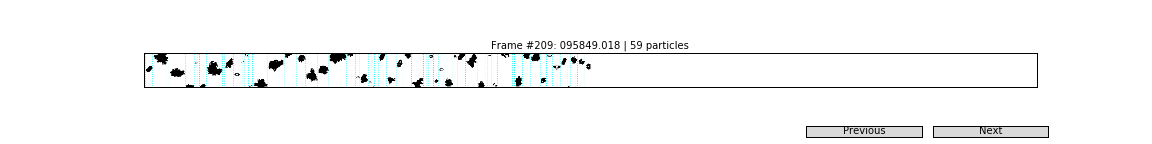

In [5]:
pos = []
def onclick(event):
    global pos
    pos = [event.xdata, event.ydata]

fig, ax = plt.subplots(1, figsize=(16,2))
implot = ax.imshow((img[0:1700,:]).T, cmap=cmap1, norm=norm)
titleStr = 'Frame #{}: {:02d}{:02d}{:02d}.{:03d} | {} particles'.format(frameStart, int(hr.values[0]),
                                                                        int(minute.values[0]), int(sec.values[0]),
                                                                        int(msec.values[0]), partCount)
ax.set_title(titleStr, size=10)
ax.set_xticks([]), ax.set_yticks([])
fig.canvas.mpl_connect('button_press_event', onclick)

class Index(object):
    ind = frameStart
    def next(self, event):
        global frameNo, hr, minute, sec, boundaryInd, partStart, partEnd, img
        self.ind += 1
        frameNo = self.ind
        [yr, mon, day, hr, minute, sec, msec, data] = get_imageData(imageFile, frameNo)
        [partCount, boundaryInd, partStart, partEnd] = get_slice_endpoints(data)
        img = image_buffer(data, probeName, boundaryInd)
        implot = ax.imshow((img[0:1700,:]).T, cmap=cmap1, norm=norm)
        titleStr = 'Frame #{}: {:02d}{:02d}{:02d}.{:03d} | {} particles'.format(frameNo, int(hr.values[0]),
                                                                                int(minute.values[0]),
                                                                                int(sec.values[0]),
                                                                                int(msec.values[0]), partCount)
        ax.set_title(titleStr, size=10)
        plt.draw()
        return frameNo
    def prev(self, event):
        global frameNo, hr, minute, sec, boundaryInd, partStart, partEnd, img
        self.ind -= 1
        frameNo = self.ind
        [yr, mon, day, hr, minute, sec, msec, data] = get_imageData(imageFile, frameNo)
        [partCount, boundaryInd, partStart, partEnd] = get_slice_endpoints(data)
        img = image_buffer(data, probeName, boundaryInd)
        implot = ax.imshow((img[0:1700,:]).T, cmap=cmap1, norm=norm)
        titleStr = 'Frame #{}: {:02d}{:02d}{:02d}.{:03d} | {} particles'.format(frameNo, int(hr.values[0]),
                                                                                int(minute.values[0]),
                                                                                int(sec.values[0]),
                                                                                int(msec.values[0]), partCount)
        ax.set_title(titleStr, size=10)
        plt.draw()
        return frameNo

callback = Index()
axprev = plt.axes([0.7, 0.05, 0.1, 0.075])
axnext = plt.axes([0.81, 0.05, 0.1, 0.075])
bnext = Button(axnext, 'Next')
bnext.on_clicked(callback.next)
bprev = Button(axprev, 'Previous')
bprev.on_clicked(callback.prev)
plt.show()

Display selected particle properties.

In [6]:
get_partInfo(probeName, pos, partStart, partEnd, hr.values[0], minute.values[0], sec.values[0], frameNo,
             time, frame, partNum, length, longestY, width, dmax, drec, dell, area, perim, reject, habit, intArr)

Time: 95842  Frame: 201  Particle: 7
Length: 34  Width: 35  LongestY: 35
Dmax: 0.937 mm  Dmax (Rectangle): 0.823 mm  Dmax (Ellipse): 0.963 mm
Area: 0.388 mm^2  Perimeter: 2.875 mm  Inter-arrival:8.30e-03 s
Reject status: Not rejected - 0  Habit: Graupel


Save image of selected particle to file.

In [7]:
img_sub = np.array(img[partStart[sel_partNum-1]:partEnd[sel_partNum-1]+1,:], dtype=np.byte)
image = smp.toimage(img_sub.T, mode='L')
outFile = '/data/gpm/a/shared/finlon2/{}/images/{}/individual/{}.{}.{}_{}.png'.format(campaign, date, probeName,
                                                                                      timeIndex[0], frameIndex[0],
                                                                                      partNumIndex[0])
image.save(outFile)
print('Particle saved out to file: {}'.format(outFile))

Particle saved out to file: /data/gpm/a/shared/finlon2/gcpex/images/20120218a/individual/CIP.95842.201_7.png
